<a href="https://colab.research.google.com/github/julianrosen/erdos_dl_recanvo_project/blob/main/sj/AST%20Feature%20Extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Extracting Features with AST

## Premise
Our work is building upon the results from a 2021 paper titled “Transfer Learning with Real-World Nonverbal Vocalizations from Minimally Speaking Individuals” [https://www.media.mit.edu/publications/transfer-learning-with-real-world-nonverbal-vocalizations-from-minimally-speaking-individuals/] We use the ReCanVo dataset that the original authors had gathered. Each audio clip is labled by caretakers with tags such as "Happy", Dysregulated" , "Hungry" , etc. Our goal is to build a classifier that predicts the label.

<br>

We use sevaral deep models to extract features from audio data including HuBert & AST. Here we focus on AST [Audio Spectrogram Transformer], which is a purely attention based model developed by Yuan Gong, Yu-An Chung, and James Glass for audio classification. [References: https://arxiv.org/pdf/2104.01778, https://github.com/YuanGongND/ast/tree/master] We use the first five layers of their model to extract features.


<br>

## This Notebook

The Goal of this notebook is to extract AST features from the audio data, and save them for later use. We do this in three scenareos. In each scenario we drop the datapoints with lables that have less than 30 data points.
- For Participant 01 we extract 4 types of features (with lables with lower than 30 data points removed)
- For Participant 05 we had already extracted features in an earlier notebook. However there were some leftover features we still have to extract.
- For the entire data set we extract the output given by the initial layer of AST

</br>





## Step 1 : Get the Data from the Recanovo Project

In [ ]:
# Get the Reconvo data from the link https://drive.google.com/uc?id=1e3ilpZosYjvGzjmO1Jaur6Ln4cJD8yAm
# unzip it and put it in the directory: /content/data

! gdown 1e3ilpZosYjvGzjmO1Jaur6Ln4cJD8yAm
! tar -xf recanvo.tar.gz
! rm recanvo.tar.gz
! mv recanvo data

Downloading...
From (original): https://drive.google.com/uc?id=1e3ilpZosYjvGzjmO1Jaur6Ln4cJD8yAm
From (redirected): https://drive.google.com/uc?id=1e3ilpZosYjvGzjmO1Jaur6Ln4cJD8yAm&confirm=t&uuid=9e52c008-69cb-4d9e-a3bf-725295957693
To: /content/recanvo.tar.gz
100% 1.06G/1.06G [00:24<00:00, 42.5MB/s]


Importing necessary packages and libraries

In [ ]:
import functools
from pathlib import Path

import torchaudio.transforms as T
import math


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


import torch
import torchaudio
from tqdm.notebook import tqdm


The train test split is made so at least one whole session is in the test set


In [ ]:
# data files [importing the new train test split made by Ale from the link: https://drive.google.com/uc?id=1zMQzBcjoMXR1FipmrFXJ0rjD7S5IgeT4]
! gdown 1zMQzBcjoMXR1FipmrFXJ0rjD7S5IgeT4 -O /content/new_train_test.csv

Downloading...
From: https://drive.google.com/uc?id=1zMQzBcjoMXR1FipmrFXJ0rjD7S5IgeT4
To: /content/new_train_test.csv
100% 523k/523k [00:00<00:00, 23.6MB/s]


In [ ]:
#create a dataframe to hold the data
df = pd.read_csv('/content/new_train_test.csv')
#check labels
display(df.Label.value_counts())

,count
Label,
selftalk,1885
frustrated,1536
delighted,1272
dysregulated,704
social,634
request,419
affectionate,129
yes,123
laughter,93


In [ ]:
Label_counts = df.Label.value_counts()
Label_enough = Label_counts[Label_counts >= 30]

In [ ]:
print(Label_enough.index)

Index(['selftalk', 'frustrated', 'delighted', 'dysregulated', 'social',
       'request', 'affectionate', 'yes', 'laughter', 'dysregulation-sick',
       'happy'],
      dtype='object', name='Label')


In [ ]:

df_dropped = df.loc[df.Label.isin(Label_enough.index)]


In [ ]:
display(df_dropped)

,Unnamed: 0,Filename,Participant,Label,is_test,Session
0,0,200126_2142_00-13-04.06--00-13-04.324.wav,P01,dysregulation-sick,0,200126_2142
1,1,200126_2142_00-06-41.54--00-06-42.47.wav,P01,dysregulation-sick,0,200126_2142
2,2,200126_2142_00-11-35.94--00-11-37.08.wav,P01,dysregulation-sick,0,200126_2142
3,3,200126_2142_00-12-11.66--00-12-15.31.wav,P01,dysregulation-sick,0,200126_2142
4,4,200126_2142_00-00-24.55--00-00-24.95.wav,P01,dysregulation-sick,1,200126_2142
...,...,...,...,...,...,...
7072,7072,210318_1436_00-00-00.0--00-00-01.05.wav,P16,delighted,1,210318_1436
7073,7073,210201_1427_00-00-07.09--00-00-07.73.wav,P16,delighted,1,210201_1427
7074,7074,210112_1705_00-01-33.50--00-01-34.27c.wav,P16,delighted,0,210112_1705
7075,7075,210112_1705_00-02-15.45--00-02-16.20c.wav,P16,delighted,0,210112_1705


In [ ]:
display(df_dropped.Label.value_counts())

,count
Label,
selftalk,1885
frustrated,1536
delighted,1272
dysregulated,704
social,634
request,419
affectionate,129
yes,123
laughter,93


In [ ]:
# create seperate datasets for train vs test data
train_all = df_dropped.loc[df_dropped.is_test == 0]
test_all = df_dropped.loc[df_dropped.is_test == 1]

In [ ]:
#Isolate the data for participant #01 and #05
df_P01 = df.loc[df.Participant == "P01"]
df_P05 = df.loc[df.Participant == "P05"]
#check labels
display(df_P05.Label.value_counts())

,count
Label,
selftalk,286
frustrated,283
delighted,235
dysregulated,116
happy,61
help,24
laughter,13
request,6
hunger,4


In [ ]:
# drop labels with count less than 30 [DOUBLE CHECK]
# P01
Label_counts1 = df_P01.Label.value_counts()
Label_enough1 = Label_counts1[Label_counts1 >= 30]

df_P01_dropped = df_P01.loc[df_P01.Label.isin(Label_enough1.index)]

# P05
Label_counts5 = df_P05.Label.value_counts()
Label_enough5 = Label_counts5[Label_counts5 >= 30]

df_P05_dropped = df_P05.loc[df_P05.Label.isin(Label_enough5.index)]

In [ ]:
display(df_P01_dropped.Label.value_counts())

,count
Label,
selftalk,564
delighted,357
dysregulated,212
social,182
frustrated,150
request,130
dysregulation-sick,74


In [ ]:
display(df_P05_dropped.Label.value_counts())

,count
Label,
selftalk,286
frustrated,283
delighted,235
dysregulated,116
happy,61


Test / Train data for each participant

In [ ]:
#create a dataframe that contains training data for participant 05
train_P05 = df_P05_dropped.loc[df_P05_dropped.is_test == 0]
test_P05 = df_P05_dropped.loc[df_P05_dropped.is_test == 1]

train_P01 = df_P01_dropped.loc[df_P01_dropped.is_test == 0]
test_P01 = df_P01_dropped.loc[df_P01_dropped.is_test == 1]

In [ ]:
#temporary cell: checking the dataframe
#print(train_P05)
print(train_P05.Label.value_counts())

Label
frustrated      208
selftalk        199
delighted       146
dysregulated     74
happy            46
Name: count, dtype: int64


In [ ]:
print(train_P01.Label.value_counts())

Label
selftalk              438
delighted             270
dysregulated          172
social                143
request               106
frustrated             99
dysregulation-sick     59
Name: count, dtype: int64


## Reformatting & Looping an Example to Fit the Input Format of AST

The sample rate for our audio files is 44.1k. To fit the input format for AST we need it to be in 16k. We also need to convert .wav files to .flac format (a compressed format), so it's in the correct input format for AST. We will also loop the audio to fit the length required to be an inout to AST.

In the following few cells, we isolate a single .wav file from our dataset and perform the reformatting and looping tasks. We will generalize it later to the entire dataset.

In [ ]:
datadir = Path('/content/data/wav')

target_sample_rate = 16000

#choosing an example
filename1 = train_P01.Filename.iloc[0]
waveform1, sample_rate1 = torchaudio.load(datadir / filename1)
resampler = T.Resample(orig_freq=sample_rate1, new_freq=target_sample_rate)
# Apply the resampler
resampled_waveform1 = resampler(waveform1)

#check shape
print(resampled_waveform1.shape)

torch.Size([2, 4224])


In [ ]:
#here we assume the waveform is names "resampled_waveform1"
#make sure to have imported the following
# import math

l = len(resampled_waveform1[0])
multiplier = math.ceil(200000 / l)
#print(multiplier)

# Create a list of the tensor repeated num_repeats times
tensors_list = [resampled_waveform1] * multiplier
# Concatenate them along the new dimension
looped_waveform = torch.cat(tensors_list, dim=1)

# Compute the end index for slicing
end_index = 200000

# Slice the tensor
trimmed_tensor0 = looped_waveform[0][:end_index]
trimmed_tensor = torch.tensor(trimmed_tensor0)
trimmed_looped_waveform1 = trimmed_tensor.unsqueeze(0)

print(trimmed_looped_waveform1.shape)

torch.Size([1, 200000])


<ipython-input-22-a055d26c6fd6>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  trimmed_tensor = torch.tensor(trimmed_tensor0)


In [ ]:
#saving the wave form
#target_sample_rate = 16000 #this was run before

torchaudio.save('output_looped1.flac', trimmed_looped_waveform1, target_sample_rate)
new_wav , new_sam = torchaudio.load('output_looped1.flac')

print(new_wav.shape)

torch.Size([1, 200000])


In [ ]:
from IPython.display import Audio

# Path to the audio file in Google Drive
audio_path = '/content/output_looped1.flac'

# Create an Audio object
audio = Audio(audio_path)

# Display the audio player
display(audio)

We will visualize thet features extracted for this example in a later section.

In the next section we will import AST and then automate the above process for each datapoint in our dataset, feed them to AST to generate features

Self Note: We may need to loop the audio files to get it to be a certain length. But we will run a trial run without it first.


# Section 2 : Importing AST

In [ ]:
#more imports

import sys
if 'google.colab' in sys.modules:
    print('Running in Colab.')
    !git clone https://github.com/YuanGongND/ast
    sys.path.append('./ast')
%cd /content/ast/

! pip install timm==0.4.5
! pip install wget
import os, csv, argparse, wget
os.environ['TORCH_HOME'] = '/content/ast/pretrained_models'
if os.path.exists('/content/ast/pretrained_models') == False:
  os.mkdir('/content/ast/pretrained_models')
import timm
from torch.cuda.amp import autocast
import IPython

Running in Colab.
Cloning into 'ast'...
remote: Enumerating objects: 649, done.
remote: Counting objects: 100% (209/209), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 649 (delta 172), reused 159 (delta 159), pack-reused 440 (from 1)
Receiving objects: 100% (649/649), 2.41 MiB | 27.08 MiB/s, done.
Resolving deltas: 100% (360/360), done.
/content/ast
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.4/287.4 kB 6.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=63dfec8c1db7940a0479c8aab5b685e20ef2168a4a5e702bbff292d8effff73f
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


Create AST model and load AudioSet pretrained weights.

In [ ]:
from src.models import ASTModel

# Create a new class that inherits the original ASTModel class
class ASTModelVis(ASTModel):
    def get_att_map(self, block, x):
        qkv = block.attn.qkv
        num_heads = block.attn.num_heads
        scale = block.attn.scale
        B, N, C = x.shape
        qkv = qkv(x).reshape(B, N, 3, num_heads, C // num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # make torchscript happy (cannot use tensor as tuple)
        attn = (q @ k.transpose(-2, -1)) * scale
        attn = attn.softmax(dim=-1)
        return attn

    def forward_visualization(self, x):
        # expect input x = (batch_size, time_frame_num, frequency_bins), e.g., (12, 1024, 128)
        x = x.unsqueeze(1)
        x = x.transpose(2, 3)

        B = x.shape[0]
        x = self.v.patch_embed(x)
        cls_tokens = self.v.cls_token.expand(B, -1, -1)
        dist_token = self.v.dist_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, dist_token, x), dim=1)
        x = x + self.v.pos_embed
        x = self.v.pos_drop(x)
        # save the attention map of each of 12 Transformer layer
        att_list = []
        for blk in self.v.blocks:
            cur_att = self.get_att_map(blk, x)
            att_list.append(cur_att)
            x = blk(x)
        return att_list

def make_features(wav_name, mel_bins, target_length=1024):
    waveform, sr = torchaudio.load(wav_name)
    assert sr == 16000, 'input audio sampling rate must be 16kHz'

    fbank = torchaudio.compliance.kaldi.fbank(
        waveform, htk_compat=True, sample_frequency=sr, use_energy=False,
        window_type='hanning', num_mel_bins=mel_bins, dither=0.0, frame_shift=10)

    n_frames = fbank.shape[0]

    p = target_length - n_frames
    if p > 0:
        m = torch.nn.ZeroPad2d((0, 0, 0, p))
        fbank = m(fbank)
    elif p < 0:
        fbank = fbank[0:target_length, :]

    fbank = (fbank - (-4.2677393)) / (4.5689974 * 2)
    return fbank

#REMOVING SINCE WE WILL NOT USE THEIR LABELS
#def load_label(label_csv):
    #with open(label_csv, 'r') as f:
        #reader = csv.reader(f, delimiter=',')
        #lines = list(reader)
    #labels = []
    #ids = []  ## Each label has a unique id such as "/m/068hy"
    #for i1 in range(1, len(lines)):
        #id = lines[i1][1]
        #label = lines[i1][2]
        #ids.append(id)
        #labels.append(label)
    #return labels

# Create an AST model and download the AudioSet pretrained weights
audioset_mdl_url = 'https://www.dropbox.com/s/cv4knew8mvbrnvq/audioset_0.4593.pth?dl=1'
if os.path.exists('/content/ast/pretrained_models/audio_mdl.pth') == False:
  wget.download(audioset_mdl_url, out='/content/ast/pretrained_models/audio_mdl.pth')

# Assume each input spectrogram has 1024 time frames
input_tdim = 1024
checkpoint_path = '/content/ast/pretrained_models/audio_mdl.pth'
# now load the visualization model
ast_mdl = ASTModelVis(label_dim=527, input_tdim=input_tdim, imagenet_pretrain=False, audioset_pretrain=False)
print(f'[*INFO] load checkpoint: {checkpoint_path}')
checkpoint = torch.load(checkpoint_path, map_location='cuda')
audio_model = torch.nn.DataParallel(ast_mdl, device_ids=[0])
audio_model.load_state_dict(checkpoint)
audio_model = audio_model.to(torch.device("cuda:0"))
audio_model.eval()

#REMOVING SINCE WE WILL NOT USE THEIR LABELS
## Load the AudioSet label set
#label_csv = '/content/ast/egs/audioset/data/class_labels_indices.csv'       ## label and indices for audioset data
#labels = load_label(label_csv)

/content/ast/src/models/ast_models.py:164: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @autocast()


---------------AST Model Summary---------------
ImageNet pretraining: False, AudioSet pretraining: False
frequncey stride=10, time stride=10
number of patches=1212
[*INFO] load checkpoint: /content/ast/pretrained_models/audio_mdl.pth


<ipython-input-26-451c6cb809a9>:81: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location='cuda')


DataParallel(
  (module): ASTModelVis(
    (v): DistilledVisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(1, 768, kernel_size=(16, 16), stride=(10, 10))
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (blocks): ModuleList(
        (0-11): 12 x Block(
          (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=768, out_features=768, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (drop_path): Identity()
          (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (act): GELU(approximate='none')
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
            (drop): 

Here we experiment with feature extraction using AST for the example we picked in the previous section

In [ ]:
# Use the make_features function to build spectrograoms and then perform some initial feature extraction process on it
feats1 = make_features('/content/output_looped1.flac', mel_bins=128)

feats1_data = feats1.expand(1, input_tdim, 128)           # reshape the feature
feats1_data = feats1_data.to(torch.device("cuda:0"))

with torch.no_grad():
  with autocast():
    att_list1 = audio_model.module.forward_visualization(feats1_data)
#REWRITE THE FOLLOWING TO NOT PRINT, BUT OUTPUT THE FEATURES IN THE DESIRED FORMAT
#print(att_list[11])


<ipython-input-27-a29ff1143657>:8: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


In [ ]:
# Tempporary Cell
print(feats1.shape)

torch.Size([1024, 128])


## Visualize the features generated by the example

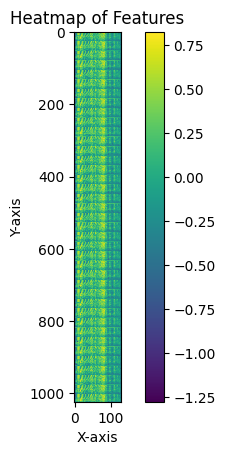

In [ ]:
# Visualize the initial features that were extracted.

# Create a heatmap
plt.imshow(feats1, cmap='viridis', interpolation='nearest')

# Add a colorbar to show the scale
plt.colorbar()

# Add labels and title if desired
plt.title('Heatmap of Features')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

# Show the plot
plt.show()

<ipython-input-30-2f47c2be0b2b>:4: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


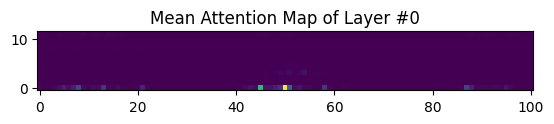

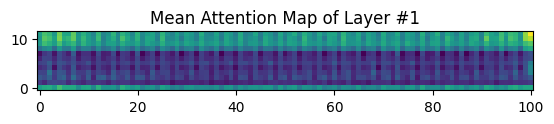

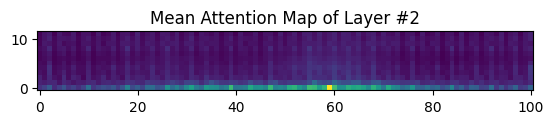

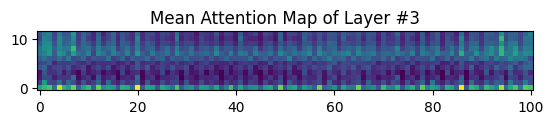

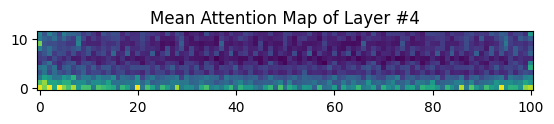

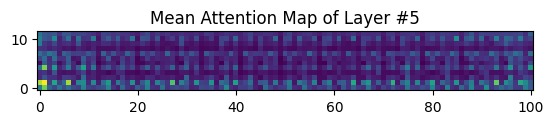

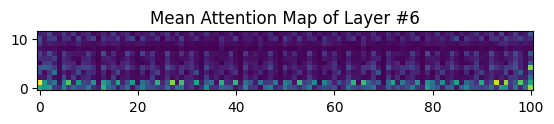

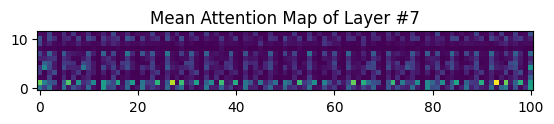

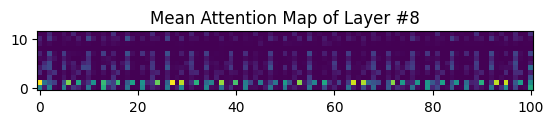

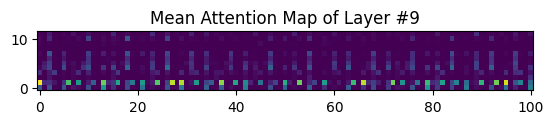

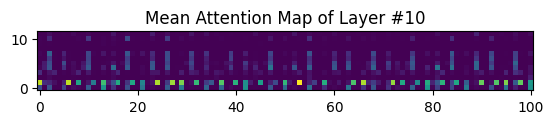

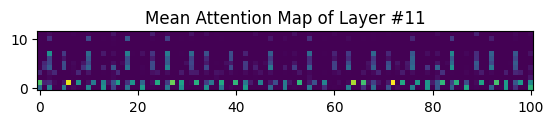

In [ ]:
# Here at att_list is built to hold the results of further layers. And they are visualized as heat maps

with torch.no_grad():
  with autocast():
    att_list1 = audio_model.module.forward_visualization(feats1_data)
for i in range(len(att_list1)):
  att_list1[i] = att_list1[i].data.cpu().numpy()
  att_list1[i] = np.mean(att_list1[i][0], axis=0)
  att_list1[i] = np.mean(att_list1[i][0:2], axis=0)
  att_list1[i] = att_list1[i][2:].reshape(12, 101)
  plt.imshow(att_list1[i], origin='lower')
  plt.title('Mean Attention Map of Layer #{:d}'.format(i))
  plt.show()
  plt.close()

Here we try the same visualization for a different example after looping the audio

# Step 3 : Extracting Features for All the Data Points corresponding to Participant 01



In [ ]:
# these were run earlier
# datadir = Path('/content/data/wav')
# import torchaudio.transforms as T
# target_sample_rate = 16000  # Target sample rate of 16 kHz

#feats_list = [] # feature list 0 # Check if this should gather feats_data instead
feats_2_list = [] # feature list 1
Att1_list = [] # feature list 2 ###
Att5_list = [] # feature list 3 ###
Att3_list = [] # feature list 4 ###

for filename in train_P01.Filename:
  waveform, sample_rate = torchaudio.load(datadir / filename)
  #resample
  resampler = T.Resample(orig_freq=sample_rate, new_freq=target_sample_rate)
  resampled_waveform = resampler(waveform) # Apply the resampler
  #loop
  l = len(resampled_waveform[0]) #take the length of the waveform
  multiplier = math.ceil(200000 / l) #create a multiplier
  tensors_list = [resampled_waveform] * multiplier  # Create a list of the tensor repeated num_repeats times
  looped_waveform = torch.cat(tensors_list, dim=1) # Concatenate them along the new dimension
  #Slice
  end_index = 200000 #the length that fit the input format for AST
  trimmed_tensor0 = looped_waveform[0][:end_index] #cutting off the tail
  trimmed_tensor = torch.tensor(trimmed_tensor0)
  trimmed_looped_waveform = trimmed_tensor.unsqueeze(0)
  #Save flac file
  torchaudio.save('output_looped.flac', trimmed_looped_waveform, target_sample_rate)
  #new_wav , new_sam = torchaudio.load('output_looped.flac') #not needed

  # use AST model to make features. Make sure the cell containing the model has been run
  feats = make_features('output_looped.flac', mel_bins=128)

  feats_data = feats.expand(1, input_tdim, 128)           # reshape the feature
  feats_data = feats_data.to(torch.device("cuda:0"))

  #make the att_list that contains the results of later layers 1 through 11. We may choose any of these as our features
  with torch.no_grad():
    with autocast():
      att_list = audio_model.module.forward_visualization(feats_data)
  for i in range(len(att_list)):
    att_list[i] = att_list[i].data.cpu().numpy()
    att_list[i] = np.mean(att_list[i][0], axis=0)
    att_list[i] = np.mean(att_list[i][0:2], axis=0)
    att_list[i] = att_list[i][2:].reshape(12, 101)

  att_list1 = torch.from_numpy(att_list[1]) #reshape to get a tensor
  att_list5 = torch.from_numpy(att_list[5]) #reshape to get a tensor
  att_list3 = torch.from_numpy(att_list[3]) #reshape to get a tensor

  #turn the feats tensor into 1 dimensional arrays in two different ways
  #feats_mean_axis1 = feats.mean(dim=1) #Averaging across the shorter direction so we get a 1024 long array instead of 1024 by 128 tensor
  feats_mean_axis0 = feats.mean(dim=0)
  att_list1_flat = torch.flatten(att_list1) #att_list[1] is two dimensional. here we concatenate rows to get a one dimensional array of length 1212
  att_list5_flat = torch.flatten(att_list5) #same as above
  att_list3_flat = torch.flatten(att_list3) #same as above

  #gather the features into previously made lists
  #feats_list.append(feats_mean_axis1)
  feats_2_list.append(feats_mean_axis0)
  Att1_list.append(att_list1_flat) ###
  Att5_list.append(att_list5_flat) ###
  Att3_list.append(att_list3_flat) ###

#X = torch.stack(feats_list).detach()
X_trainP1_1 = torch.stack(feats_2_list).detach()
X_trainP1_2 = torch.stack(Att1_list).detach() ###
X_trainP1_3 = torch.stack(Att5_list).detach() ###
X_trainP1_4 = torch.stack(Att3_list).detach() ###

labels = train_P01.Label.unique()
y_trainP1 = torch.zeros(len(train_P01), dtype=torch.int)
for idx, label in enumerate(labels):
    y_trainP1[(train_P01.Label == label).values] = idx
print(X_trainP1_1.shape, y_trainP1.shape)


<ipython-input-35-5afe00603ec4>:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  trimmed_tensor = torch.tensor(trimmed_tensor0)
<ipython-input-35-5afe00603ec4>:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


torch.Size([1287, 128]) torch.Size([1287])


In [ ]:
print(X_trainP1_2.shape, X_trainP1_3.shape, X_trainP1_4.shape)

torch.Size([1287, 1212]) torch.Size([1287, 1212]) torch.Size([1287, 1212])


In [ ]:
from google.colab import files

# Save the tensor to a file
torch.save(X_trainP1_1, 'X_trainP1_1.pt')
# Download the file
files.download('X_trainP1_1.pt')

torch.save(X_trainP1_2, 'X_trainP1_2.pt')
files.download('X_trainP1_2.pt')

torch.save(X_trainP1_3, 'X_trainP1_3.pt')
files.download('X_trainP1_3.pt')

torch.save(X_trainP1_4, 'X_trainP1_4.pt')
files.download('X_trainP1_4.pt')

torch.save(y_trainP1, 'y_trainP1.pt')
files.download('y_trainP1.pt')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# these were run earlier
# datadir = Path('/content/data/wav')
# import torchaudio.transforms as T
# target_sample_rate = 16000  # Target sample rate of 16 kHz

#feats_list = [] # feature list 0 # Check if this should gather feats_data instead
feats_2_list = [] # feature list 1
Att1_list = [] # feature list 2 ###
Att5_list = [] # feature list 3 ###
Att3_list = [] # feature list 4 ###

for filename in test_P01.Filename:
  waveform, sample_rate = torchaudio.load(datadir / filename)
  #resample
  resampler = T.Resample(orig_freq=sample_rate, new_freq=target_sample_rate)
  resampled_waveform = resampler(waveform) # Apply the resampler
  #loop
  l = len(resampled_waveform[0]) #take the length of the waveform
  multiplier = math.ceil(200000 / l) #create a multiplier
  tensors_list = [resampled_waveform] * multiplier  # Create a list of the tensor repeated num_repeats times
  looped_waveform = torch.cat(tensors_list, dim=1) # Concatenate them along the new dimension
  #Slice
  end_index = 200000 #the length that fit the input format for AST
  trimmed_tensor0 = looped_waveform[0][:end_index] #cutting off the tail
  trimmed_tensor = torch.tensor(trimmed_tensor0)
  trimmed_looped_waveform = trimmed_tensor.unsqueeze(0)
  #Save flac file
  torchaudio.save('output_looped.flac', trimmed_looped_waveform, target_sample_rate)
  #new_wav , new_sam = torchaudio.load('output_looped.flac') #not needed

  # use AST model to make features. Make sure the cell containing the model has been run
  feats = make_features('output_looped.flac', mel_bins=128)

  feats_data = feats.expand(1, input_tdim, 128)           # reshape the feature
  feats_data = feats_data.to(torch.device("cuda:0"))

  #make the att_list that contains the results of later layers 1 through 11. We may choose any of these as our features
  with torch.no_grad():
    with autocast():
      att_list = audio_model.module.forward_visualization(feats_data)
  for i in range(len(att_list)):
    att_list[i] = att_list[i].data.cpu().numpy()
    att_list[i] = np.mean(att_list[i][0], axis=0)
    att_list[i] = np.mean(att_list[i][0:2], axis=0)
    att_list[i] = att_list[i][2:].reshape(12, 101)

  att_list1 = torch.from_numpy(att_list[1]) #reshape to get a tensor
  att_list5 = torch.from_numpy(att_list[5]) #reshape to get a tensor
  att_list3 = torch.from_numpy(att_list[3]) #reshape to get a tensor

  #turn the feats tensor into 1 dimensional arrays in two different ways
  #feats_mean_axis1 = feats.mean(dim=1) #Averaging across the shorter direction so we get a 1024 long array instead of 1024 by 128 tensor
  feats_mean_axis0 = feats.mean(dim=0)
  att_list1_flat = torch.flatten(att_list1) #att_list[1] is two dimensional. here we concatenate rows to get a one dimensional array of length 1212
  att_list5_flat = torch.flatten(att_list5) #same as above
  att_list3_flat = torch.flatten(att_list3) #same as above

  #gather the features into previously made lists
  #feats_list.append(feats_mean_axis1)
  feats_2_list.append(feats_mean_axis0)
  Att1_list.append(att_list1_flat) ###
  Att5_list.append(att_list5_flat) ###
  Att3_list.append(att_list3_flat) ###

#X = torch.stack(feats_list).detach()
X_testP1_1 = torch.stack(feats_2_list).detach()
X_testP1_2 = torch.stack(Att1_list).detach() ###
X_testP1_3 = torch.stack(Att5_list).detach() ###
X_testP1_4 = torch.stack(Att3_list).detach() ###

labels = test_P01.Label.unique()
y_testP1 = torch.zeros(len(test_P01), dtype=torch.int)
for idx, label in enumerate(labels):
    y_testP1[(test_P01.Label == label).values] = idx
print(X_testP1_1.shape, y_testP1.shape)

## A later part of this cell gave an error which part I copied to the next cell and ran again.

<ipython-input-39-df419e36bc0e>:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  trimmed_tensor = torch.tensor(trimmed_tensor0)
<ipython-input-39-df419e36bc0e>:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


torch.Size([382, 128]) torch.Size([382])


FileNotFoundError: Cannot find file: X_testP1_2.pt

In [ ]:
print(X_testP1_2.shape, X_testP1_3.shape, X_testP1_4.shape)

torch.Size([382, 1212]) torch.Size([382, 1212]) torch.Size([382, 1212])


In [ ]:
#Save the Tensors
torch.save(X_testP1_1, 'X_testP1_1.pt')
files.download('X_testP1_1.pt')

torch.save(X_testP1_2, 'X_testP1_2.pt')
files.download('X_testP1_2.pt')

torch.save(X_testP1_3, 'X_testP1_3.pt')
files.download('X_testP1_3.pt')

torch.save(X_testP1_4, 'X_testP1_4.pt')
files.download('X_testP1_4.pt')

torch.save(y_testP1, 'y_testP1.pt')
files.download('y_testP1.pt')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Section 4 : Extracting Features for the Entire Dataset

SELF NOTE: PERHAPS DO THE FOLLOWING ONLY FOR X_1 TO SAVE TIME

In [ ]:
# training features [DOUBLE CHECK]
# [PERHAPS DO THIS ONLY FOR X_1 TO SAVE TIME]

# these were run earlier
# datadir = Path('/content/data/wav')
# import torchaudio.transforms as T
# target_sample_rate = 16000  # Target sample rate of 16 kHz

#feats_list = [] # feature list 0 # Check if this should gather feats_data instead
feats_2_list = [] # feature list 1
##Att1_list = [] # feature list 2 ###
##Att5_list = [] # feature list 3 ###
##Att3_list = [] # feature list 4 ###

for filename in train_all.Filename:
  waveform, sample_rate = torchaudio.load(datadir / filename)
  #resample
  resampler = T.Resample(orig_freq=sample_rate, new_freq=target_sample_rate)
  resampled_waveform = resampler(waveform) # Apply the resampler
  #loop
  l = len(resampled_waveform[0]) #take the length of the waveform
  multiplier = math.ceil(200000 / l) #create a multiplier
  tensors_list = [resampled_waveform] * multiplier  # Create a list of the tensor repeated num_repeats times
  looped_waveform = torch.cat(tensors_list, dim=1) # Concatenate them along the new dimension
  #Slice
  end_index = 200000 #the length that fit the input format for AST
  trimmed_tensor0 = looped_waveform[0][:end_index] #cutting off the tail
  trimmed_tensor = torch.tensor(trimmed_tensor0)
  trimmed_looped_waveform = trimmed_tensor.unsqueeze(0)
  #Save flac file
  torchaudio.save('output_looped.flac', trimmed_looped_waveform, target_sample_rate)
  #new_wav , new_sam = torchaudio.load('output_looped.flac') #not needed

  # use AST model to make features. Make sure the cell containing the model has been run
  feats = make_features('output_looped.flac', mel_bins=128)

  feats_data = feats.expand(1, input_tdim, 128)           # reshape the feature
  feats_data = feats_data.to(torch.device("cuda:0"))

  #make the att_list that contains the results of later layers 1 through 11. We may choose any of these as our features
  ##with torch.no_grad():
    ##with autocast():
      ##att_list = audio_model.module.forward_visualization(feats_data)
  ##for i in range(len(att_list)):
    ##att_list[i] = att_list[i].data.cpu().numpy()
    ##att_list[i] = np.mean(att_list[i][0], axis=0)
    ##att_list[i] = np.mean(att_list[i][0:2], axis=0)
    ##att_list[i] = att_list[i][2:].reshape(12, 101)

  ##att_list1 = torch.from_numpy(att_list[1]) #reshape to get a tensor
  ##att_list5 = torch.from_numpy(att_list[5]) #reshape to get a tensor
  ##att_list3 = torch.from_numpy(att_list[3]) #reshape to get a tensor

  #turn the feats tensor into 1 dimensional arrays in two different ways
  #feats_mean_axis1 = feats.mean(dim=1) #Averaging across the shorter direction so we get a 1024 long array instead of 1024 by 128 tensor
  feats_mean_axis0 = feats.mean(dim=0)
  ##att_list1_flat = torch.flatten(att_list1) #att_list[1] is two dimensional. here we concatenate rows to get a one dimensional array of length 1212
  ##att_list5_flat = torch.flatten(att_list5) #same as above
  ##att_list3_flat = torch.flatten(att_list3) #same as above

  #gather the features into previously made lists
  #feats_list.append(feats_mean_axis1)
  feats_2_list.append(feats_mean_axis0)
  ##Att1_list.append(att_list1_flat) ###
  ##Att5_list.append(att_list5_flat) ###
  ##Att3_list.append(att_list3_flat) ###

#X = torch.stack(feats_list).detach()
X_train_1 = torch.stack(feats_2_list).detach()
##X_train_2 = torch.stack(Att1_list).detach() ###
##X_train_3 = torch.stack(Att5_list).detach() ###
##X_train_4 = torch.stack(Att3_list).detach() ###

labels = train_all.Label.unique()
y_train = torch.zeros(len(train_all), dtype=torch.int)
for idx, label in enumerate(labels):
    y_train[(train_all.Label == label).values] = idx
print(X_train_1.shape, y_train.shape)

<ipython-input-42-ddfed0dc6ec7>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  trimmed_tensor = torch.tensor(trimmed_tensor0)


torch.Size([4962, 128]) torch.Size([4962])


In [ ]:
#save tensors
torch.save(X_train_1, 'X_train_1.pt')
files.download('X_train_1.pt')

##torch.save(X_train_2, 'X_train_2.pt')
##files.download('X_train_2.pt')

##torch.save(X_train_3, 'X_train_3.pt')
##files.download('X_train_3.pt')

##torch.save(X_train_4, 'X_train_4.pt')
##files.download('X_train_4.pt')

torch.save(y_train, 'y_train.pt')
files.download('y_train.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Features for the Test Set

In [ ]:
# Test Features [DOUBLE CHECK]

# these were run earlier
# datadir = Path('/content/data/wav')
# import torchaudio.transforms as T
# target_sample_rate = 16000  # Target sample rate of 16 kHz

#feats_list = [] # feature list 0 # Check if this should gather feats_data instead
feats_2_list = [] # feature list 1
##Att1_list = [] # feature list 2 ###
##Att5_list = [] # feature list 3 ###
##Att3_list = [] # feature list 4 ###

for filename in test_all.Filename:
  waveform, sample_rate = torchaudio.load(datadir / filename)
  #resample
  resampler = T.Resample(orig_freq=sample_rate, new_freq=target_sample_rate)
  resampled_waveform = resampler(waveform) # Apply the resampler
  #loop
  l = len(resampled_waveform[0]) #take the length of the waveform
  multiplier = math.ceil(200000 / l) #create a multiplier
  tensors_list = [resampled_waveform] * multiplier  # Create a list of the tensor repeated num_repeats times
  looped_waveform = torch.cat(tensors_list, dim=1) # Concatenate them along the new dimension
  #Slice
  end_index = 200000 #the length that fit the input format for AST
  trimmed_tensor0 = looped_waveform[0][:end_index] #cutting off the tail
  trimmed_tensor = torch.tensor(trimmed_tensor0)
  trimmed_looped_waveform = trimmed_tensor.unsqueeze(0)
  #Save flac file
  torchaudio.save('output_looped.flac', trimmed_looped_waveform, target_sample_rate)
  #new_wav , new_sam = torchaudio.load('output_looped.flac') #not needed

  # use AST model to make features. Make sure the cell containing the model has been run
  feats = make_features('output_looped.flac', mel_bins=128)

  feats_data = feats.expand(1, input_tdim, 128)           # reshape the feature
  feats_data = feats_data.to(torch.device("cuda:0"))

  #make the att_list that contains the results of later layers 1 through 11. We may choose any of these as our features
  ##with torch.no_grad():
    ##with autocast():
      ##att_list = audio_model.module.forward_visualization(feats_data)
  ##for i in range(len(att_list)):
    ##att_list[i] = att_list[i].data.cpu().numpy()
    ##att_list[i] = np.mean(att_list[i][0], axis=0)
    ##att_list[i] = np.mean(att_list[i][0:2], axis=0)
    ##att_list[i] = att_list[i][2:].reshape(12, 101)

  ##att_list1 = torch.from_numpy(att_list[1]) #reshape to get a tensor
  ##att_list5 = torch.from_numpy(att_list[5]) #reshape to get a tensor
  ##att_list3 = torch.from_numpy(att_list[3]) #reshape to get a tensor

  #turn the feats tensor into 1 dimensional arrays in two different ways
  #feats_mean_axis1 = feats.mean(dim=1) #Averaging across the shorter direction so we get a 1024 long array instead of 1024 by 128 tensor
  feats_mean_axis0 = feats.mean(dim=0)
  ##att_list1_flat = torch.flatten(att_list1) #att_list[1] is two dimensional. here we concatenate rows to get a one dimensional array of length 1212
  ##att_list5_flat = torch.flatten(att_list5) #same as above
  ##att_list3_flat = torch.flatten(att_list3) #same as above

  #gather the features into previously made lists
  #feats_list.append(feats_mean_axis1)
  feats_2_list.append(feats_mean_axis0)
  ##Att1_list.append(att_list1_flat) ###
  ##Att5_list.append(att_list5_flat) ###
  ##Att3_list.append(att_list3_flat) ###

#X = torch.stack(feats_list).detach()
X_test_1 = torch.stack(feats_2_list).detach()
##X_test_2 = torch.stack(Att1_list).detach() ###
##X_test_3 = torch.stack(Att5_list).detach() ###
##X_test_4 = torch.stack(Att3_list).detach() ###

labels = test_all.Label.unique()
y_test = torch.zeros(len(test_all), dtype=torch.int)
for idx, label in enumerate(labels):
    y_test[(test_all.Label == label).values] = idx
print(X_test_1.shape, y_test.shape)

<ipython-input-44-248d42715038>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  trimmed_tensor = torch.tensor(trimmed_tensor0)


torch.Size([1968, 128]) torch.Size([1968])


In [ ]:
#Save the Tensors
torch.save(X_test_1, 'X_test_1.pt')
files.download('X_test_1.pt')

##torch.save(X_test_2, 'X_test_2.pt')
##files.download('X_test_2.pt')

##torch.save(X_test_3, 'X_test_3.pt')
##files.download('X_test_3.pt')

##torch.save(X_test_4, 'X_test_4.pt')
##files.download('X_test_4.pt')

torch.save(y_test, 'y_test.pt')
files.download('y_test.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Section 5 : Extracting Features for the Test Data of Participant 05

This is a leftover step that we didn't do in the previous notebook.

In [ ]:
# these were run earlier
# datadir = Path('/content/data/wav')
# import torchaudio.transforms as T
# target_sample_rate = 16000  # Target sample rate of 16 kHz

#feats_list = [] # feature list 0 # Check if this should gather feats_data instead
feats_2_list = [] # feature list 1
Att1_list = [] # feature list 2 ###
Att5_list = [] # feature list 3 ###
Att3_list = [] # feature list 4 ###

for filename in test_P05.Filename:
  waveform, sample_rate = torchaudio.load(datadir / filename)
  #resample
  resampler = T.Resample(orig_freq=sample_rate, new_freq=target_sample_rate)
  resampled_waveform = resampler(waveform) # Apply the resampler
  #loop
  l = len(resampled_waveform[0]) #take the length of the waveform
  multiplier = math.ceil(200000 / l) #create a multiplier
  tensors_list = [resampled_waveform] * multiplier  # Create a list of the tensor repeated num_repeats times
  looped_waveform = torch.cat(tensors_list, dim=1) # Concatenate them along the new dimension
  #Slice
  end_index = 200000 #the length that fit the input format for AST
  trimmed_tensor0 = looped_waveform[0][:end_index] #cutting off the tail
  trimmed_tensor = torch.tensor(trimmed_tensor0)
  trimmed_looped_waveform = trimmed_tensor.unsqueeze(0)
  #Save flac file
  torchaudio.save('output_looped.flac', trimmed_looped_waveform, target_sample_rate)
  #new_wav , new_sam = torchaudio.load('output_looped.flac') #not needed

  # use AST model to make features. Make sure the cell containing the model has been run
  feats = make_features('output_looped.flac', mel_bins=128)

  feats_data = feats.expand(1, input_tdim, 128)           # reshape the feature
  feats_data = feats_data.to(torch.device("cuda:0"))

  #make the att_list that contains the results of later layers 1 through 11. We may choose any of these as our features
  with torch.no_grad():
    with autocast():
      att_list = audio_model.module.forward_visualization(feats_data)
  for i in range(len(att_list)):
    att_list[i] = att_list[i].data.cpu().numpy()
    att_list[i] = np.mean(att_list[i][0], axis=0)
    att_list[i] = np.mean(att_list[i][0:2], axis=0)
    att_list[i] = att_list[i][2:].reshape(12, 101)

  att_list1 = torch.from_numpy(att_list[1]) #reshape to get a tensor
  att_list5 = torch.from_numpy(att_list[5]) #reshape to get a tensor
  att_list3 = torch.from_numpy(att_list[3]) #reshape to get a tensor

  #turn the feats tensor into 1 dimensional arrays in two different ways
  #feats_mean_axis1 = feats.mean(dim=1) #Averaging across the shorter direction so we get a 1024 long array instead of 1024 by 128 tensor
  feats_mean_axis0 = feats.mean(dim=0)
  att_list1_flat = torch.flatten(att_list1) #att_list[1] is two dimensional. here we concatenate rows to get a one dimensional array of length 1212
  att_list5_flat = torch.flatten(att_list5) #same as above
  att_list3_flat = torch.flatten(att_list3) #same as above

  #gather the features into previously made lists
  #feats_list.append(feats_mean_axis1)
  feats_2_list.append(feats_mean_axis0)
  Att1_list.append(att_list1_flat) ###
  Att5_list.append(att_list5_flat) ###
  Att3_list.append(att_list3_flat) ###

#X = torch.stack(feats_list).detach()
X_testP5_1 = torch.stack(feats_2_list).detach()
X_testP5_2 = torch.stack(Att1_list).detach() ###
X_testP5_3 = torch.stack(Att5_list).detach() ###
X_testP5_4 = torch.stack(Att3_list).detach() ###

labels = test_P05.Label.unique()
y_testP5 = torch.zeros(len(test_P05), dtype=torch.int)
for idx, label in enumerate(labels):
    y_testP5[(test_P05.Label == label).values] = idx
print(X_testP5_1.shape, y_testP5.shape)

<ipython-input-31-be94200350d9>:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  trimmed_tensor = torch.tensor(trimmed_tensor0)
<ipython-input-31-be94200350d9>:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


IndexError: The shape of the mask [308] at index 0 does not match the shape of the indexed tensor [673] at index 0

In [ ]:
y_testP5 = torch.zeros(len(test_P05), dtype=torch.int)
for idx, label in enumerate(labels):
    y_testP5[(test_P05.Label == label).values] = idx
print(X_testP5_1.shape, y_testP5.shape)

torch.Size([308, 128]) torch.Size([308])


In [ ]:
from google.colab import files

#Save the Tensors
torch.save(X_testP5_1, 'X_testP5_1.pt')
files.download('X_testP5_1.pt')

torch.save(X_testP5_2, 'X_testP5_2.pt')
files.download('X_testP5_2.pt')

torch.save(X_testP5_3, 'X_testP5_3.pt')
files.download('X_testP5_3.pt')

torch.save(X_testP5_4, 'X_testP5_4.pt')
files.download('X_testP5_4.pt')

torch.save(y_testP5, 'y_testP5.pt')
files.download('y_testP5.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Outputs for P05 training data

In [ ]:
labels = train_P05.Label.unique()
y_trainP5 = torch.zeros(len(train_P05), dtype=torch.int)
for idx, label in enumerate(labels):
    y_trainP5[(train_P05.Label == label).values] = idx
print(y_trainP5.shape)

torch.Size([673])


In [ ]:
from google.colab import files

#save the tensor
torch.save(y_trainP5, 'y_trainP5.pt')
files.download('y_trainP5.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>